# Simple regression

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel, cv_adaptation, one_model_inference, simple_cv_adaptation
from pcv.plots import plot_model_results, plot_fold_results, plot_rhats
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt
import arviz as az

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

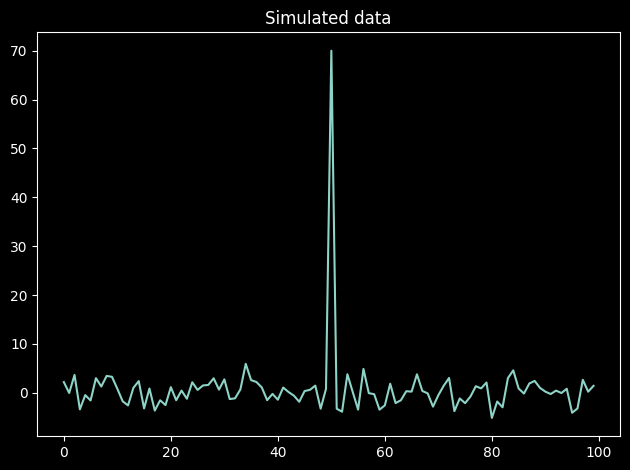

In [3]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.7]),
    sigsq0 = jnp.array(2.0))
y = y.at[50].set(70)

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [4]:
K = 10
model = reg.get_model(y, X, K=K)

First, run model diagnostics.

In [5]:
idata, state = one_model_inference(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    model_id=0,
    num_chains=32,
    num_samples=10_000,
    warmup_iter=10_000,
    prior_only=False
)

GHMC alpha: 0.5881, delta: 0.2941, step size: 0.4504


In [6]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.013,0.575,-0.093,2.069,0.003,0.002,46954.0,75508.0,1.0
beta[1],2.570,0.550,1.537,3.606,0.002,0.002,59855.0,96057.0,1.0
beta[2],0.737,0.490,-0.194,1.648,0.002,0.001,71173.0,110795.0,1.0
beta[3],-0.303,0.544,-1.326,0.718,0.002,0.002,53942.0,87244.0,1.0
sigsq,29.822,2.902,24.534,35.351,0.012,0.009,56773.0,90158.0,1.0


In [7]:
print(f"Saw {state.divergences.sum()} divergences")

Saw 0 divergences


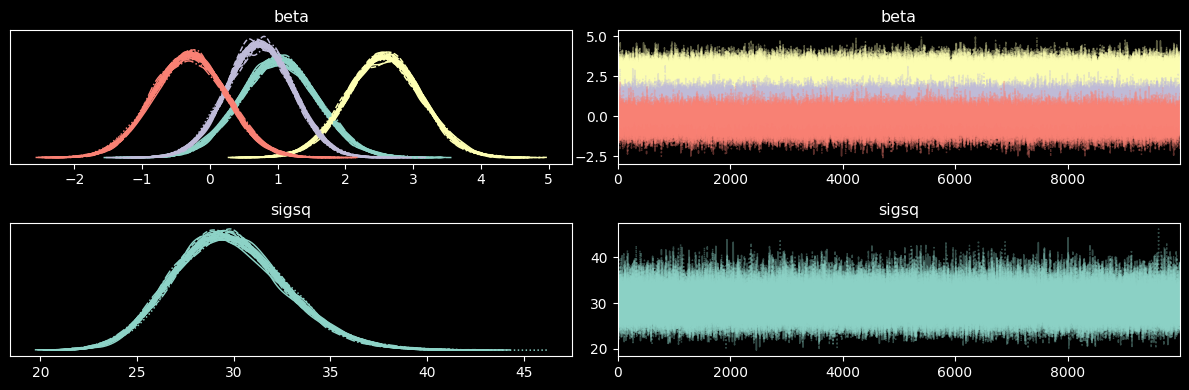

In [8]:
axes = az.plot_trace(idata)
plt.tight_layout()

## Cross-Validation


In [9]:
warmup_results = simple_cv_adaptation(
    prng_key=jax.random.PRNGKey(42),
    model=model,
    warmup_model_id=0,
    num_chains=4,
    adaptation_iter=1_000,
    burnin_iter=500,
    batch_size=100,
)

MEADS warmup for 2 model(s) (8 chains)...
Meads warmup done in 4.02 seconds. 
Step size: 0.4761 Alpha: 0.5867 Delta: 0.2933
Approximated 20 modes in 0 min 0.8 sec
Burn-in for 80 chains run took 0 min 4.7 sec


In [10]:
results = run_cv_sel(
       prng_key=jax.random.PRNGKey(0),
       model=model,
       stoprule=make_positive_negative_rule(num_folds=model.num_folds, level=0.95),
       warmup_results=warmup_results,
       batch_size=100,
       max_batches=50,
       ignore_stoprule=True,
       prior_only=False
)

Starting cross-validation with 80 parallel GHMC chains...
   0.  Model A: -1523.37 ±1250.61 ess 10608, Model B: -1009.02 ±737.53 ess 10830
       Diff: -514.35 ±513.08, Rhat < 1.0672  stop
       Triggered stoprule after 1 batches in 4 seconds
  10.  Model A: -1293.56 ±1020.56 ess 29764, Model B: -995.83 ±724.36 ess 29122
       Diff: -297.73 ±296.20, Rhat < 1.0262  stop
  20.  Model A: -1252.61 ±979.51 ess 46902, Model B: -996.31 ±724.84 ess 47751
       Diff: -256.30 ±254.67, Rhat < 1.0136  stop
  30.  Model A: -1236.25 ±963.20 ess 65701, Model B: -996.61 ±725.17 ess 66033
       Diff: -239.63 ±238.03, Rhat < 1.0135  stop
  40.  Model A: -1236.50 ±963.44 ess 83609, Model B: -996.87 ±725.41 ess 84307
       Diff: -239.63 ±238.03, Rhat < 1.0087  stop
  49.  Model A: -1236.67 ±963.62 ess 99485, Model B: -997.04 ±725.58 ess 100792
       Diff: -239.63 ±238.04, Rhat < 1.0090  stop
Drew 400000 samples in 1 min 44 sec (3840 per sec)


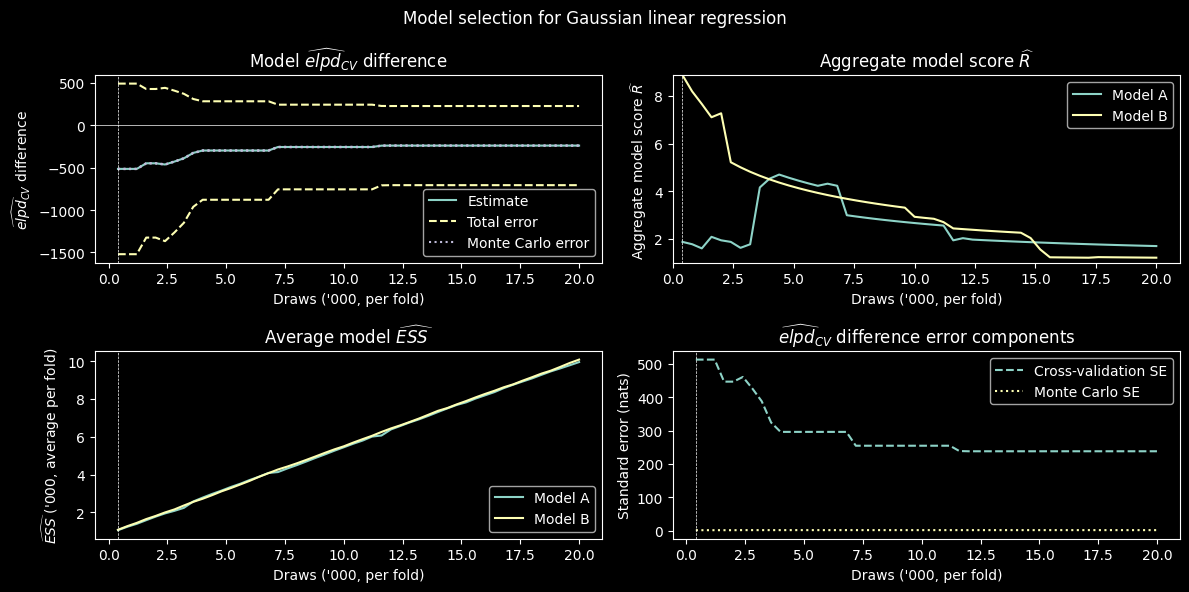

In [11]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

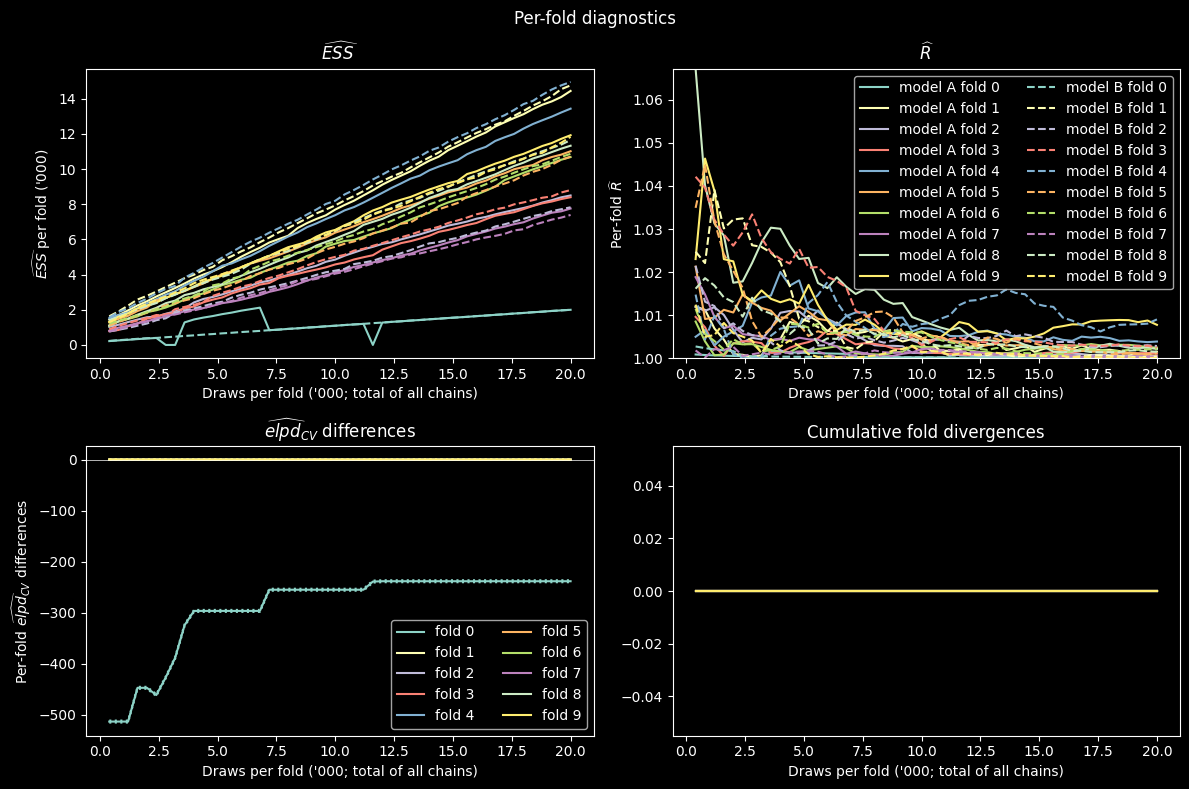

In [12]:
plot_fold_results(results, title='Per-fold diagnostics')

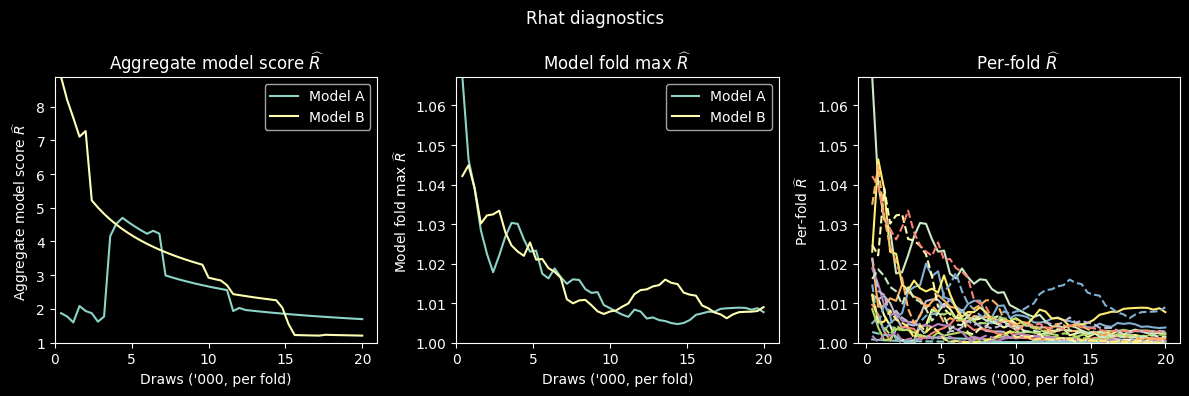

In [13]:
plot_rhats(results)